# **Model Development - Algeris Data - 1 Day**
by: Argish Abhangi

Preprocessing of the data during Phase 3 provided deep insights about the data features.<br> 
Now, we'll be trainig an LSTM model for our final preprocessed algeris dataset.


`Model info:` **7 Days** Prior data input ➡ lstm_model ➡ **1 days** ahead prediction output

Model - `LSTM` <br>
Trainig Metrics used - `MSE` <br> 
Optimizer used - `Adam` 

#### Importing Libraries

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [ ]:
# Load the training and testing datasets
train_data_path = '../data/train_algiers.csv'
test_data_path = '../data/test_algiers.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head(), test_data.head()

#### Data Transformation and Normalization

In [ ]:
# Convert 'date' to datetime and set as index
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

# Check for missing values
missing_values_train = train_data.isnull().sum()
missing_values_test = test_data.isnull().sum()

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Convert scaled data back to DataFrame for easier handling
train_scaled_df = pd.DataFrame(train_scaled, columns=train_data.columns, index=train_data.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_data.columns, index=test_data.index)

missing_values_train, missing_values_test, train_scaled_df.head(), test_scaled_df.head()

In [5]:
def create_dataset(X, y, time_steps_in=1, time_steps_out=1):
    """
    Create a dataset for LSTM with specified number of input and output time steps.
    
    :param X: Input features
    :param y: Target feature
    :param time_steps_in: Number of time steps to use as input
    :param time_steps_out: Number of time steps to predict
    :return: reshaped input and output for LSTM model
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps_in - time_steps_out + 1):
        v = X.iloc[i:(i + time_steps_in)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps_in:i + time_steps_in + time_steps_out].values)
    
    return np.array(Xs), np.array(ys)

# Number of time steps for input and output
time_steps_in, time_steps_out = 7, 1

X_train, y_train = create_dataset(train_scaled_df.drop('water_availability', axis=1), train_scaled_df['water_availability'], time_steps_in, time_steps_out)
X_test, y_test = create_dataset(test_scaled_df.drop('water_availability', axis=1), test_scaled_df['water_availability'], time_steps_in, time_steps_out)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2443, 7, 31), (2443, 1), (538, 7, 31), (538, 1))

### **Model Training**

In [6]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_layer_size)
        out = self.linear(hn)
        return out

# Model parameters
input_size = 31  # Number of features
hidden_layer_size = 50  # Can be modified to optimize performance
output_size = time_steps_out  # Predicting x time steps into the future

# Instantiate the model
model = LSTMModel(input_size, hidden_layer_size, output_size)
model.to(device)

model

LSTMModel(
  (lstm): LSTM(31, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [8]:
# Training parameters
learning_rate = 0.0001
num_epochs = 200 

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [15]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# UnComment to save the weights
# torch.save(model.state_dict(), './trained_model/Algeris_01_Day.pt')

"Model training complete and model saved."

Epoch [10/200], Loss: 0.0052
Epoch [20/200], Loss: 0.0052
Epoch [30/200], Loss: 0.0052
Epoch [40/200], Loss: 0.0051
Epoch [50/200], Loss: 0.0051
Epoch [60/200], Loss: 0.0051
Epoch [70/200], Loss: 0.0050
Epoch [80/200], Loss: 0.0050
Epoch [90/200], Loss: 0.0050
Epoch [100/200], Loss: 0.0050
Epoch [110/200], Loss: 0.0049
Epoch [120/200], Loss: 0.0049
Epoch [130/200], Loss: 0.0049
Epoch [140/200], Loss: 0.0049
Epoch [150/200], Loss: 0.0049
Epoch [160/200], Loss: 0.0048
Epoch [170/200], Loss: 0.0048
Epoch [180/200], Loss: 0.0048
Epoch [190/200], Loss: 0.0048
Epoch [200/200], Loss: 0.0048


'Model training complete and model saved.'

### **Evaluating the model**

In [16]:
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)

test_loss.item()

0.004606639500707388

#### Metrics before inverse transform

In [17]:
test_predictions_np = test_predictions.detach().cpu().numpy()

mse = mean_squared_error(y_test, test_predictions_np)
rmse = root_mean_squared_error(y_test, test_predictions_np)
mae = mean_absolute_error(y_test, test_predictions_np)

print(f"mse: {mse:.4f}")
print(f"mae: {mae:.4f}")
print(f"rmse: {rmse:.4f}")

mse: 0.0046
mae: 0.0401
rmse: 0.0679


#### Inverse Transforming predictions and y_test

In [18]:
num_features = train_data.shape[1] 

last_step_predictions = test_predictions.detach().cpu().numpy()[:, -1]
dummies = np.zeros((last_step_predictions.shape[0], num_features))
dummies[:, -1] = last_step_predictions
dummies_transformed = scaler.inverse_transform(dummies)
inverse_transformed_test_predictions = dummies_transformed[:, -1]

y_test_last_step = y_test[:, -1]
y_test_dummies = np.zeros((y_test.shape[0], num_features))
y_test_dummies[:, -1] = y_test_last_step
y_test_dummies_transformed = scaler.inverse_transform(y_test_dummies)
inverse_transformed_y_test = y_test_dummies_transformed[:, -1]


####  Visualizing the results

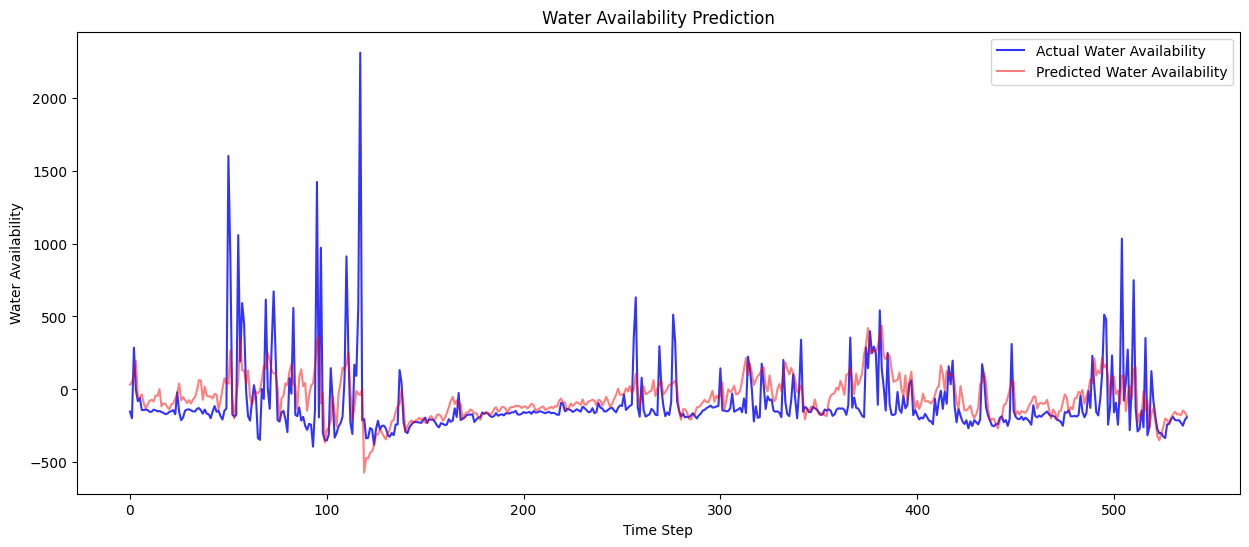

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(inverse_transformed_y_test, label='Actual Water Availability', color='blue', alpha=0.8)  # Use inverse transformed data
plt.plot(inverse_transformed_test_predictions, label='Predicted Water Availability', color='red', alpha=0.5)
plt.title('Water Availability Prediction')
plt.xlabel('Time Step')
plt.ylabel('Water Availability')
plt.legend()
plt.show()

#### Metrics after inverse transform

In [20]:
mse = mean_squared_error(inverse_transformed_y_test, inverse_transformed_test_predictions)
rmse = root_mean_squared_error(inverse_transformed_y_test, inverse_transformed_test_predictions)
mae = mean_absolute_error(inverse_transformed_y_test, inverse_transformed_test_predictions)

print(f"mse: {mse:.4f}")
print(f"mae: {mae:.4f}")
print(f"rmse: {rmse:.4f}")

mse: 48745.7362
mae: 130.3350
rmse: 220.7844
